# WFP - Ellip training over Nigeria

October 2019

This notebook monitors the progress of the SNAC data processing pipeline and shows how to discover, query and plot the results.

In [32]:
import pandas as pd
import cioppy
import time
import os
import sys
sys.path.append(os.getcwd())
from wfp_nigeria_helpers import *
from shapely.geometry import box
from shapely.wkt import loads
import gdal
import osr

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
gdal.UseExceptions()

%load_ext autoreload
%autoreload 2

%store -r
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Authentication

In [42]:
if not 'username' in locals():
    username = raw_input('What is your Terradue username?')
    %store username

Stored 'username' (str)


Set the API key associated to the Terradue username. 

It is available at this link: https://www.terradue.com/portal/settings/apikey (it requires a login with the Terradue username)

In [43]:
if not 'api_key' in locals():
    api_key = getpass.getpass('And your Terradue API key:')
    %store api_key
   

Stored 'api_key' (str)


Load the serialized data items catalogue references:


In [2]:
data_items = pd.read_pickle('snac.pkl')

In [3]:
data_items

self
0   https://catalog.terradue.com/fbrito/search?uid...
1   https://catalog.terradue.com/fbrito/search?uid...
2   https://catalog.terradue.com/fbrito/search?uid...
3   https://catalog.terradue.com/fbrito/search?uid...
4   https://catalog.terradue.com/fbrito/search?uid...
5   https://catalog.terradue.com/fbrito/search?uid...
6   https://catalog.terradue.com/fbrito/search?uid...
7   https://catalog.terradue.com/fbrito/search?uid...
8   https://catalog.terradue.com/fbrito/search?uid...
9   https://catalog.terradue.com/fbrito/search?uid...
10  https://catalog.terradue.com/fbrito/search?uid...
11  https://catalog.terradue.com/fbrito/search?uid...

Add the columns for storing the status and link to the results:

In [4]:
data_items['status'] = ''
data_items['link_results'] = ''

In [5]:
data_items

self status link_results
0   https://catalog.terradue.com/fbrito/search?uid...                    
1   https://catalog.terradue.com/fbrito/search?uid...                    
2   https://catalog.terradue.com/fbrito/search?uid...                    
3   https://catalog.terradue.com/fbrito/search?uid...                    
4   https://catalog.terradue.com/fbrito/search?uid...                    
5   https://catalog.terradue.com/fbrito/search?uid...                    
6   https://catalog.terradue.com/fbrito/search?uid...                    
7   https://catalog.terradue.com/fbrito/search?uid...                    
8   https://catalog.terradue.com/fbrito/search?uid...                    
9   https://catalog.terradue.com/fbrito/search?uid...                    
10  https://catalog.terradue.com/fbrito/search?uid...                    
11  https://catalog.terradue.com/fbrito/search?uid...

Monitor the status of each of the data items:

In [10]:
creds = ':'.join([username, api_key])

while not ((len(data_items['status'].unique()) == 1) and (str(data_items['status'].unique()[0]) == 'source-out')):
   
    data_items.update(data_items.apply(lambda row: check_status(row, creds), axis=1))
    
    print data_items['status'].unique()
   
    time.sleep(120)

If the status is *source-out*, the data items have now a link pointing to the results:

In [11]:
data_items

self      status  \
0   https://catalog.terradue.com/fbrito/search?uid...  source-out   
1   https://catalog.terradue.com/fbrito/search?uid...  source-out   
2   https://catalog.terradue.com/fbrito/search?uid...  source-out   
3   https://catalog.terradue.com/fbrito/search?uid...  source-out   
4   https://catalog.terradue.com/fbrito/search?uid...  source-out   
5   https://catalog.terradue.com/fbrito/search?uid...  source-out   
6   https://catalog.terradue.com/fbrito/search?uid...  source-out   
7   https://catalog.terradue.com/fbrito/search?uid...  source-out   
8   https://catalog.terradue.com/fbrito/search?uid...  source-out   
9   https://catalog.terradue.com/fbrito/search?uid...  source-out   
10  https://catalog.terradue.com/fbrito/search?uid...  source-out   
11  https://catalog.terradue.com/fbrito/search?uid...  source-out   

                                         link_results  
0   https://catalog.terradue.com/fbrito/cat/183fa0...  
1   https://catalog.terradue.com/fbrito/cat/076094...  
2   https://catalog.terradue.com/fbrito/cat/cdca2f...  
3   https://catalog.terradue.com/fbrito/cat/f0c2c7...  
4   https://catalog.terradue.com/fbrito/cat/e1495d...  
5   https://catalog.terradue.com/fbrito/cat/a781dc...  
6   https://catalog.terradue.com/fbrito/cat/3e00eb...  
7   https://catalog.terradue.com/fbrito/cat/d681ab...  
8   https://catalog.terradue.com/fbrito/cat/952194...  
9   https://catalog.terradue.com/fbrito/cat/63be6a...  
10  https://catalog.terradue.com/fbrito/cat/4b2d29...  
11  https://catalog.terradue.com/fbrito/cat/9a21b6...

For each data item, use the link:results to discover what has been produced.

Aggregate all results in a single Pandas data frame:

In [46]:
search_results = pd.DataFrame()

for index, row in data_items.iterrows():
    
    tmp_results = pd.DataFrame.from_dict(cioppy.Cioppy().search(end_point=row.link_results, 
                                                                params=[],
                                                                output_fields='self,identifier,enclosure,title,link:results,wkt',
                                                                model='GeoTime',
                                                                creds=creds))
    tmp_results['geometry'] = tmp_results['wkt'].apply(loads)
    tmp_results = tmp_results.drop(columns=['wkt'])
    
    if index == 0:
        search_results = tmp_results
    else:
        search_results = pd.concat([search_results, tmp_results])
    
search_results = gpd.GeoDataFrame(search_results.reset_index(drop=True))

In [47]:
rgb_amplitude_change = gpd.GeoDataFrame(search_results[(search_results.title.str.contains('RGB_Amplitude_Change'))])

In [48]:
rgb_amplitude_change.cx[:, :0]

enclosure  \
16  https://store.terradue.com/fbrito/_results/wor...   

                                  identifier  \
16  9D27F026F3232DDC7BDBE14132D2484DA6268D89   

                                         link:results  \
16  https://catalog.terradue.com/fbrito/search?uid...   

                                                 self  \
16  https://catalog.terradue.com//fbrito/cat/a781d...   

                                                title  \
16  S1_GRD_VV_20190911_20180916_RGB_Amplitude_Chan...   

                                             geometry  
16  POLYGON ((5.24196311417881 10.1021278503686, 7...

Filter the results using a bounding box:

In [56]:
aoi_bbox = '5.743,13.017,5.811,13.08'

In [57]:
intersections = gpd.overlay(rgb_amplitude_change,
                            gpd.GeoDataFrame(gpd.GeoSeries(box(*[float(coord) for coord in aoi_bbox.split(',')])), 
                                             columns=['geometry']),
                            how='intersection')

In [58]:
intersections

enclosure  \
0  https://store.terradue.com/fbrito/_results/wor...   

                                 identifier  \
0  0FDE13EA97D77D52A941C09801F37F97FD20617F   

                                        link:results  \
0  https://catalog.terradue.com/fbrito/search?uid...   

                                                self  \
0  https://catalog.terradue.com//fbrito/cat/e1495...   

                                               title  \
0  S1_GRD_VV_20190911_20180916_RGB_Amplitude_Chan...   

                                            geometry  
0  POLYGON ((5.811 13.017, 5.743 13.017, 5.743 13...

Now plot the amplitude change RGB:

In [23]:
aoi = [float(coord) for coord in aoi_bbox.split(',')]

In [24]:
aoi

[5.743, 13.017, 5.811, 13.08]

S1_GRD_VV_20190911_20180916_RGB_Amplitude_Change.tif
(713, 750, 4)


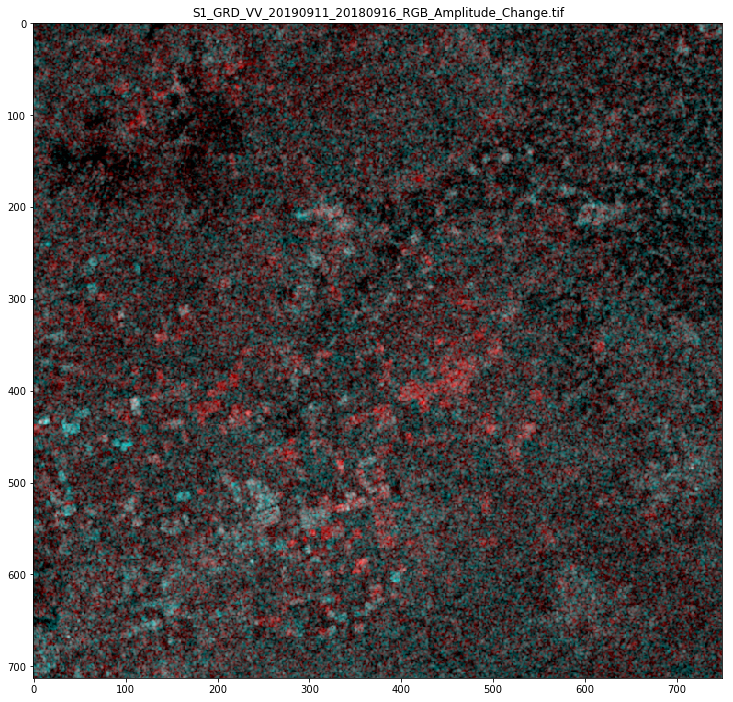

In [59]:
fig = plt.figure(figsize=(20,20))

i=1
for index, row in intersections.iterrows():
   
    print (row.title)
    
    img_data = vsi_download(row, 
                       aoi, 
                       username, 
                       api_key)

    print img_data.shape
    
    a=fig.add_subplot(2, 2, 0+i)
    a.set_title(row.title)
    width = 12
    height = 12
   
    if img_data.shape[2] == 4:
        
        data = np.dstack((img_data[:,:,0], 
                           img_data[:,:,1],
                           img_data[:,:,2])).astype(np.uint8) 
 
        img = Image.fromarray(data)
        imgplot = plt.imshow(img)

    else:
        
        data = img_data
    
        imgplot = plt.imshow(data.reshape(data.shape[0],data.shape[1]), cmap=plt.cm.gray)

    i = i+1
        
plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()

## License

This work is licenced under a Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0) YOU ARE FREE TO:
- Share - copy and redistribute the material in any medium or format.
- Adapt - remix, transform, and built upon the material for any purpose, even commercially.

**UNDER THE FOLLOWING TERMS:**
- Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
- ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.